In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
import sys
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'

if ros_path in sys.path:

    sys.path.remove(ros_path)

import cv2

sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Dropout, Conv2D, MaxPooling2D, Flatten, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from scipy.special import softmax
from keras import optimizers
%matplotlib inline


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Model

In [2]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

left_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=left_img, input_shape=(112,112,3))
left_phi_features = left_phi_model.output
left_flat = Flatten(name='left-phi-flattened')(left_phi_features)

# fx
pred_fx = Dense(1, name='fx')(left_flat)

# fy
pred_fy = Dense(1, name='fy')(left_flat)

# u0
pred_u0 = Dense(1, name='u0')(left_flat)

# v0
pred_v0 = Dense(1, name='v0')(left_flat)

# baseline
pred_baseline = Dense(1, name='baseline')(left_flat)

# tx
pred_x = Dense(1, name='x')(left_flat)

# ty
pred_y = Dense(1, name='y')(left_flat)

# tz
pred_z = Dense(1, name='z')(left_flat)

# pitch
pred_pitch = Dense(1, name='pitch')(left_flat)

# u
pred_u = Dense(1, name='u')(left_flat)

# v
pred_v = Dense(1, name='v')(left_flat)

# disparity
pred_disparity = Dense(1, name='disparity')(left_flat)

# yWorld
pred_yWorld = Dense(1, name='yWorld')(left_flat)

# xWorld
pred_xWorld = Dense(1, name='xWorld')(left_flat)

# zWorld
pred_zWorld = Dense(1, name='zWorld')(left_flat)

# create model
model = Model(inputs=[left_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
plot_model(model, to_file='model.png')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         left_image[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 55, 55, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 55, 55, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

ValueError: Could not interpret optimizer identifier: <keras.optimizers.Adam object at 0x7fadcc6587c0>

# Get data

In [3]:
data_path = "../Data/"

Left_images = np.load(data_path+"li.npy")
Right_images = np.load(data_path+"ri.npy")
Fx = np.load(data_path+"fx.npy")
Fy = np.load(data_path+"fy.npy") 
U0 = np.load(data_path+"u0.npy") 
V0 = np.load(data_path+"v0.npy") 
Baseline = np.load(data_path+"b.npy")
Disparity = np.load(data_path+"d.npy") 
Tx = np.load(data_path+"tx.npy") 
Ty = np.load(data_path+"ty.npy") 
Tz = np.load(data_path+"tz.npy") 
Pitch = np.load(data_path+"p.npy")
X = np.load(data_path+"x.npy")
Y = np.load(data_path+"y.npy") 
Z = np.load(data_path+"z.npy")


In [6]:
import os
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

model_name = 'model_multi_class/'
SAVE = "new_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
# Save
output_folder = SAVE + model_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_log = output_folder + "Log/"
if not os.path.exists(output_log):
    os.makedirs(output_log)

output_weight = output_folder + "Best/"
if not os.path.exists(output_weight):
    os.makedirs(output_weight)


input_shape = (112, 112, 3)

tensorboard = TensorBoard(log_dir=output_log)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)

csv_logger = CSVLogger('training.log')


checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=output_weight + "weights_{epoch:02d}_{val_loss:.2f}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

history = model.fit(
    x=[Left_images[:int(len(Left_images)*0.7)]],
    y=[Fx[:int(len(Left_images)*0.7)], Fy[:int(len(Left_images)*0.7)], U0[:int(len(Left_images)*0.7)], V0[:int(len(Left_images)*0.7)], Baseline[:int(len(Left_images)*0.7)], Disparity[:int(len(Left_images)*0.7)], Tx[:int(len(Left_images)*0.7)], Ty[:int(len(Left_images)*0.7)], Tz[:int(len(Left_images)*0.7)], Pitch[:int(len(Left_images)*0.7)], X[:int(len(Left_images)*0.7)], Y[:int(len(Left_images)*0.7)], Z[:int(len(Left_images)*0.7)]],
    batch_size=16,
    epochs=200,
    verbose=1,
    shuffle=True,
    initial_epoch=0,
    validation_data=([Left_images[int(len(Left_images)*0.7):]], [Fx[int(len(Left_images)*0.7):], Fy[int(len(Left_images)*0.7):], U0[int(len(Left_images)*0.7):], V0[int(len(Left_images)*0.7):], Baseline[int(len(Left_images)*0.7):], Disparity[int(len(Left_images)*0.7):], Tx[int(len(Left_images)*0.7):], Ty[int(len(Left_images)*0.7):], Tz[int(len(Left_images)*0.7):], Pitch[int(len(Left_images)*0.7):], X[int(len(Left_images)*0.7):], Y[int(len(Left_images)*0.7):], Z[int(len(Left_images)*0.7):]]),
    callbacks=[tensorboard, checkpointer, early_stopping, csv_logger]
)

Train on 55524 samples, validate on 23796 samples
Epoch 1/200
55524/55524 [==============================] - ETA: 0s - loss: 27.5762 - fx_loss: 3.7708 - fy_loss: 3.7775 - u0_loss: 0.5514 - v0_loss: 0.5508 - baseline_loss: 0.5111 - disparity_loss: 0.3340 - x_loss: 0.5174 - y_loss: 0.6500 - z_loss: 0.5707 - pitch_loss: 2.5145 - xWorld_loss: 4.8018 - yWorld_loss: 2.5233 - zWorld_loss: 6.5094

/home/talha/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55524/55524 [==============================] - 504s 9ms/sample - loss: 27.5762 - fx_loss: 3.7708 - fy_loss: 3.7775 - u0_loss: 0.5514 - v0_loss: 0.5508 - baseline_loss: 0.5111 - disparity_loss: 0.3340 - x_loss: 0.5174 - y_loss: 0.6500 - z_loss: 0.5707 - pitch_loss: 2.5145 - xWorld_loss: 4.8018 - yWorld_loss: 2.5233 - zWorld_loss: 6.5094 - val_loss: 21.5850 - val_fx_loss: 2.1723 - val_fy_loss: 2.7211 - val_u0_loss: 0.9990 - val_v0_loss: 1.4261 - val_baseline_loss: 0.2855 - val_disparity_loss: 0.3653 - val_x_loss: 0.6991 - val_y_loss: 0.4845 - val_z_loss: 0.7571 - val_pitch_loss: 2.6460 - val_xWorld_loss: 3.1175 - val_yWorld_loss: 2.4206 - val_zWorld_loss: 3.4910
Epoch 2/200
55524/55524 [==============================] - 475s 9ms/sample - loss: 16.7531 - fx_loss: 2.2211 - fy_loss: 2.2235 - u0_loss: 0.3822 - v0_loss: 0.3951 - baseline_loss: 0.3878 - disparity_loss: 0.2882 - x_loss: 0.4006 - y_loss: 0.4961 - z_loss: 0.4257 - pitch_loss: 1.5150 - xWorld_loss: 2.7184 - yWorld_loss: 1.5726 - z

Epoch 00012: early stopping


In [4]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20220912-153203/model_multi_class/Best/weights_07_10.11.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images[int(len(Left_images)*0.7):]],
    batch_size=16,
    verbose=1
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [7]:
np.shape(output)

(13, 23796, 1)

Text(0, 0.5, '% Correct')

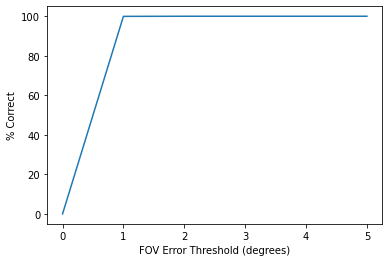

In [8]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 55524

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [9]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 23781, 23796, 23796, 23796, 23796)

In [10]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 0.9993696419566314, 1.0, 1.0)

In [5]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 1.286216490572841, 'fy': 1.3617292269398404, 'u0': 0.4937650231999256, 'v0': 0.6355269044602613, 'baseline': 0.13129135592331664, 'disparity': 0.3337598006217669, 'x': 0.15337508699687152, 'y': 0.160628789677968, 'z': 0.16428160049230398, 'pitch': 1.0439506068432465, 'xworld': 1.5492911808480934, 'yworld': 0.8043879380865393, 'zworld': 1.9885211813851058}


# Normalized MAE

In [6]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 84.70939817976283

mean_fy = 84.70939817976283

mean_u0 = 56.0

mean_v0 = 56.0

mean_baseline = 3.1362834089762988

mean_disparity = 5.6359135359419765

mean_tx = 3.1362834089762988

mean_ty = 3.2890401748192972

mean_tz = 2.8612371827197847

mean_pitch = 84.54614220877458

mean_xw = 31.613377053172897

mean_yw = 25.092866140117593

mean_zw = 42.71013880363322


key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.015183870009836663, 'fy': 0.016075302814102018, 'u0': 0.008817232557141548, 'v0': 0.011348694722504623, 'baseline': 0.041862082854996485, 'disparity': 0.059220177615088986, 'x': 0.048903452589105875, 'y': 0.048837588214255295, 'z': 0.057416281839363, 'pitch': 0.012347702444723767, 'xworld': 0.04900745587041302, 'yworld': 0.032056439212437615, 'zworld': 0.04655852771931992}
